### Regularized Linear Models


#### Ridge Regression


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
np.random.seed(42)
m = 20
X = 3*np.random.rand(m, 1)
y = 1 + .5*X + np.random.randn(m, 1)/1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

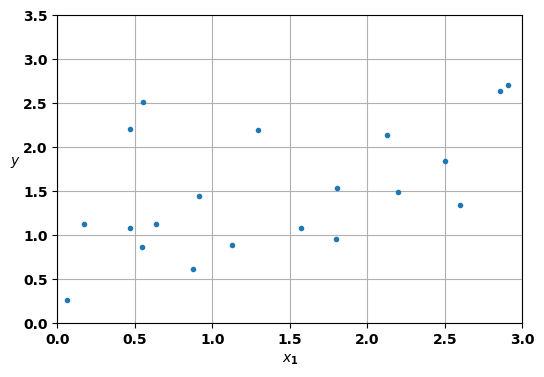

In [9]:
plt.figure(figsize=(6, 4))
plt.plot(X, y, ".")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)
plt.axis([0, 3, 0, 3.5])
plt.grid()
plt.show()

In [10]:
model = sk.Ridge(alpha=0.1, solver='cholesky')
model.fit(X, y)
model.predict([[1.5]])

array([[1.55325833]])

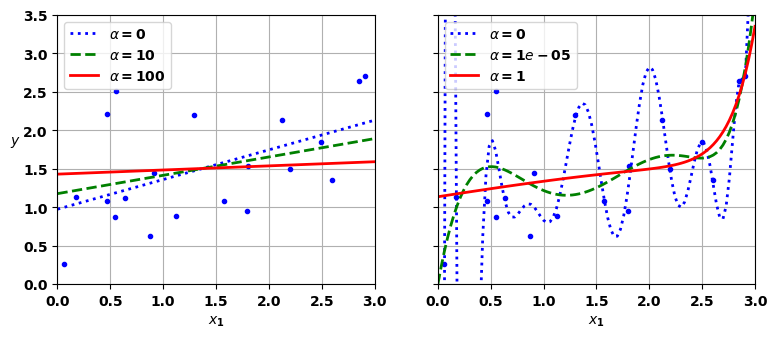

In [19]:
def plot_model(model_class, polynomial, alphas, **model_kwargs):
    plt.plot(X, y, "b.", linewidth=3)
    for alpha, style in zip(alphas, ("b:", "g--", "r-")):
        if alpha > 0:
            model = model_class(alpha, **model_kwargs)
        else:
            model = LinearRegression()
        if polynomial:
            model = make_pipeline(
                PolynomialFeatures(degree=15, include_bias=False),
                StandardScaler(),
                model)
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        plt.plot(X_new, y_new_regul, style, linewidth=2,
                 label=fr"$\alpha = {alpha}$")
    plt.legend(loc="upper left")
    plt.xlabel("$x_1$")
    plt.axis([0, 3, 0, 3.5])
    plt.grid()


plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
plt.show()

> The previous model (Ridge) is using closed form solution (using matrices).

Let's Try SGD


In [20]:
from sklearn.linear_model import SGDRegressor

model = SGDRegressor(alpha=.1/m, penalty='l2', tol=None,
                     max_iter=1000, eta0=0.01, random_state=42)
model.fit(X, y.ravel())
model.predict([[1.5]])

array([1.55302613])

using ridge with solver = stochastic average gradient descent(sag)


In [21]:
model = Ridge(alpha=.1, solver='sag', random_state=42)
model.fit(X, y)
model.predict([[1.5]])

array([[1.55326019]])

### Lasso


In [22]:
from sklearn.linear_model import Lasso
model = Lasso(alpha=0.1)
model.fit(X, y)
model.predict([[1.5]])

array([1.53788174])

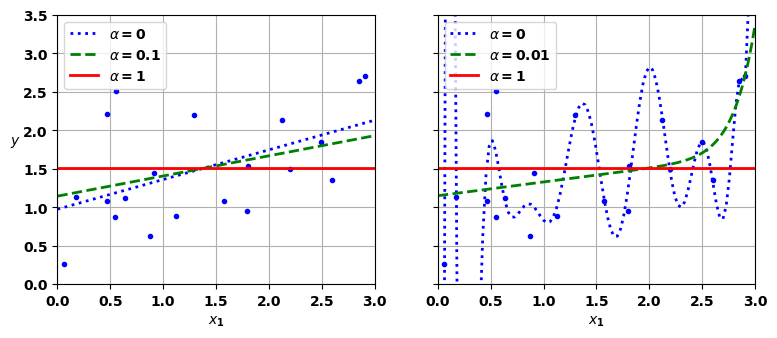

In [23]:
plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 1e-2, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
plt.show()

ElasticNET


In [24]:
from sklearn.linear_model import ElasticNet
model = ElasticNet(alpha=.1, l1_ratio=.5)
model.fit(X, y)
model.predict([[1.5]])

array([1.54333232])

### Early Stopping


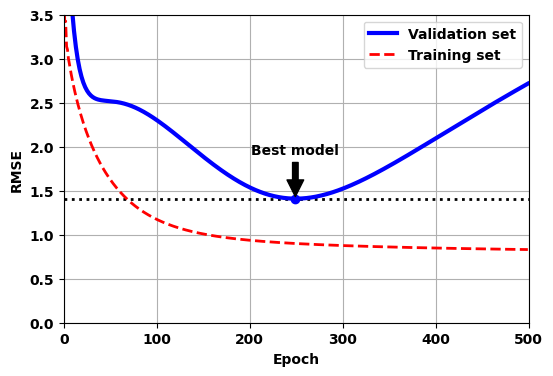

In [26]:
from copy import deepcopy
from sklearn.metrics import mean_squared_error
np.random.seed(42)

m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)
X_train, y_train = X[: m // 2], y[: m // 2, 0]
X_valid, y_valid = X[m // 2:], y[m // 2:, 0]

model = SGDRegressor(penalty=None, eta0=0.002, random_state=42)
preprocessing = make_pipeline(PolynomialFeatures(
    degree=90, include_bias=False), StandardScaler())

X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)

epochs = 500
best_valid_rmse = float('inf')
train_errors, val_errors = [], []

for epoch in range(epochs):
    model.partial_fit(X_train_prep, y_train)
    y_valid_predict = model.predict(X_valid_prep)
    error = mean_squared_error(y_valid, y_valid_predict, squared=False)
    if error < best_valid_rmse:
        best_valid_rmse = error
        best_model = deepcopy(model)
    y_train_predict = model.predict(X_train_prep)
    tr_error = mean_squared_error(y_train, y_train_predict, squared=False)
    train_errors.append(tr_error)
    val_errors.append(error)

best_epoch = np.argmin(val_errors)

plt.figure(figsize=(6, 4))
plt.annotate('Best model',
             xy=(best_epoch, best_valid_rmse),
             xytext=(best_epoch, best_valid_rmse + 0.5),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot([0, epochs], [best_valid_rmse, best_valid_rmse], "k:", linewidth=2)
plt.plot(val_errors, "b-", linewidth=3, label="Validation set")
plt.plot(best_epoch, best_valid_rmse, "bo")
plt.plot(train_errors, "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.axis([0, epochs, 0, 3.5])
plt.grid()
plt.show()